# [2D] Decision Making Model with ``SlowPointFinder``

In [1]:
import brainpy as bp
import brainpy.math as bm

bp.math.enable_x64()
# bp.math.set_platform('cpu')

In [2]:
# parameters
gamma = 0.641  # Saturation factor for gating variable
tau = 0.06  # Synaptic time constant [sec]
a = 270.
b = 108.
d = 0.154

In [3]:
JE = 0.3725  # self-coupling strength [nA]
JI = -0.1137  # cross-coupling strength [nA]
JAext = 0.00117  # Stimulus input strength [nA]

In [4]:
mu = 20.  # Stimulus firing rate [spikes/sec]
coh = 0.5  # Stimulus coherence [%]
Ib1 = 0.3297
Ib2 = 0.3297

In [5]:
@bp.odeint
def int_s1(s1, t, s2, coh=0.5, mu=20.):
  I1 = JE * s1 + JI * s2 + Ib1 + JAext * mu * (1. + coh)
  r1 = (a * I1 - b) / (1. - bm.exp(-d * (a * I1 - b)))
  return - s1 / tau + (1. - s1) * gamma * r1

In [6]:
@bp.odeint
def int_s2(s2, t, s1, coh=0.5, mu=20.):
  I2 = JE * s2 + JI * s1 + Ib2 + JAext * mu * (1. - coh)
  r2 = (a * I2 - b) / (1. - bm.exp(-d * (a * I2 - b)))
  return - s2 / tau + (1. - s2) * gamma * r2

In [7]:
def cell(s):
  ds1 = int_s1.f(s[0], 0., s[1])
  ds2 = int_s2.f(s[1], 0., s[0])
  return bm.asarray([ds1, ds2])

In [8]:
finder = bp.analysis.SlowPointFinder(f_cell=cell, f_type='continuous')
finder.find_fps_with_gd_method(
  candidates=bm.random.random((1000, 2)),
  tolerance=1e-5, num_batch=200,
  optimizer=bp.optim.Adam(lr=bp.optim.ExponentialDecay(0.01, 1, 0.9999)),
)
finder.filter_loss(1e-5)
finder.keep_unique()

print('fixed_points: ', finder.fixed_points)
print('losses:', finder.losses)

Optimizing with Adam(lr=ExponentialDecay(0.01, decay_steps=1, decay_rate=0.9999), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-200 in 0.31 sec, Training loss 0.0543390532
    Batches 201-400 in 0.25 sec, Training loss 0.0052048551
    Batches 401-600 in 0.25 sec, Training loss 0.0008121170
    Batches 601-800 in 0.23 sec, Training loss 0.0001853616
    Batches 801-1000 in 0.25 sec, Training loss 0.0000455684
    Batches 1001-1200 in 0.24 sec, Training loss 0.0000116649
    Batches 1201-1400 in 0.23 sec, Training loss 0.0000030255
    Stop optimization as mean training loss 0.0000030255 is below tolerance 0.0000100000.
Excluding fixed points with squared speed above tolerance 1e-05:
    Kept 969/1000 fixed points with tolerance under 1e-05.
Excluding non-unique fixed points:
    Kept 3/969 unique fixed points with uniqueness tolerance 0.025.
fixed_points:  [[0.28276323 0.40635171]
 [0.01394651 0.65738904]
 [0.70045189 0.00486431]]
losses: [7.74275831e-32 1.1470

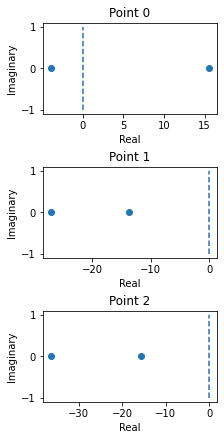

In [9]:
jac = finder.compute_jacobians(finder.fixed_points, plot=True, num_col=1)